# Stage 2 Absolute Calibration Nightly Notebook

**Josh Dillon**, Last Revised 9/23/20

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from hera_cal import io, redcal, apply_cal, abscal, utils
from hera_cal.smooth_cal import build_time_blacklist
from hera_qm.metrics_io import load_metric_file
import pyuvdata
import glob
import os
from copy import deepcopy
import inspect
import h5py
import matplotlib.cm as cm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# If you want to run this notebook locally, copy the output of the next cell into the first few lines of this cell.

# JD = '2459122'
# data_path = '/lustre/aoc/projects/hera/H4C/2459122'
# lst_blacklist_string = '0-1.3 2.5-4.3 5.0-5.7 6.5-9.1 10.6-11.5 11.9-14.3 16.3-1.3'
# abscal_model_glob = '/lustre/aoc/projects/hera/zmartino/hera_calib_model/H3C/abscal_files_unique_baselines/zen.2458894.?????.uvh5'
# os.environ["JULIANDATE"] = JD
# os.environ["DATA_PATH"] = data_path
# os.environ["LST_BLACKLIST_STRING"] = lst_blacklist_string
# os.environ["ABSCAL_MODEL_GLOB"] = abscal_model_glob

In [3]:
# Use environment variables to figure out path to data
JD = os.environ['JULIANDATE']
data_path = os.environ['DATA_PATH']
lst_blacklist_string = os.environ['LST_BLACKLIST_STRING']
abscal_model_glob = os.environ['ABSCAL_MODEL_GLOB']
print(f'JD = "{JD}"')
print(f'data_path = "{data_path}"')
print(f'lst_blacklist_string = "{lst_blacklist_string}"')
print(f'abscal_model_glob = "{abscal_model_glob}"')

JD = "2458069"
data_path = "/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/2458069"
lst_blacklist_string = ""
abscal_model_glob = "/lustre/aoc/projects/hera/nkern/idr3_abscal_models/full_model/zen.245804*.HH.uvRXLS.uvh5"


In [4]:
print('Looking for data in', data_path, 'on JD', JD)
data_list = sorted(glob.glob(os.path.join(data_path, f'zen.{JD}.?????.sum.uvh5')))
if len(data_list) == 0:
    data_list = sorted(glob.glob(os.path.join(data_path, f'zen.{JD}.?????.uvh5')))
print('...found {} data files.'.format(len(data_list)))

abscal_list = sorted(glob.glob(os.path.join(data_path, f'zen.{JD}.*.abs.calfits')))
print('...found {} abscal files.'.format(len(abscal_list)))

omnical_list = sorted(glob.glob(os.path.join(data_path, f'zen.{JD}.*.sum.omni.calfits')))
print('...found {} omnical files.'.format(len(omnical_list)))

Looking for data in /lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/2458069 on JD 2458069
...found 73 data files.
...found 73 abscal files.
...found 73 omnical files.


# Load And Inspect a Single File

In [5]:
# get all JDs and LSTs
_, _, file_lst_arrays, file_time_arrays = io.get_file_times(data_list)
# parse lst_blacklist_string
lst_blacklists = []
if len(lst_blacklist_string) > 0:
    lst_blacklists = [tuple([float(arg) for arg in arg_pair.split('-', maxsplit=1)]) 
                      for arg_pair in lst_blacklist_string.split(' ')]

# get times that are blacklisted and reshape them like file_time_arrays
time_blacklisted_flat = build_time_blacklist(np.hstack(file_time_arrays), lst_blacklists=lst_blacklists)
time_blacklisted = deepcopy(file_time_arrays).astype(bool)
n = 0
for i in range(len(file_time_arrays)):
    time_blacklisted[i] = np.zeros_like(time_blacklisted[i], dtype=bool)
    for j in range(len(file_time_arrays[i])):
        time_blacklisted[i][j] = time_blacklisted_flat[n]
        n += 1

# pick the central time from among the not-LST blacklisted files, if possible
good_indices = [i for i, tb in enumerate(time_blacklisted) if not np.any(tb)]
if len(good_indices) > 0:
    file_index = good_indices[len(good_indices)//2]
else:
    file_index = len(data_list)//2
file_JD = '.'.join([s for s in data_list[file_index].split('.') if s.isdigit()])    

/lustre/aoc/projects/hera/heramgr/anaconda2/envs/h1c_idr3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: setting an array element with a sequence.

In [6]:
# Load abscal gains and determine ex_ants
hc = io.HERACal(abscal_list[file_index])
gains, gain_flags, _, _ = hc.read()
ex_ants = [ant for ant in gain_flags if np.all(gain_flags[ant])]

# Get min_bl_cut, we only want to compare baselines actually used in absolute calibration
try:
    min_bl_cut = float(hc.history.replace('\n','').split('--min_bl_cut')[-1].split('--')[0].strip())
except:
    print('Could not find min_bl_cut, setting to 1 m.')
    min_bl_cut = 1.0

# Load the most common redundant baseline longer than min_bl_cut
hd = io.HERAData(data_list[file_index])
bls_to_plot = []
for pol in ['ee', 'nn']:
    reds = redcal.get_reds(hd.antpos, pols=[pol])
#     reds = redcal.filter_reds(reds, ex_ants=ex_ants)
    reds = sorted(reds, key=len, reverse=True)
    bl_lens = np.array([np.linalg.norm(hd.antpos[red[0][1]] - hd.antpos[red[0][0]]) for red in reds])
    try:
        bl_group_to_plot = (np.array(reds)[bl_lens >= min_bl_cut])[0]
    except:
        bl_group_to_plot = reds[0]
    bls_to_plot.extend(bl_group_to_plot)
    
# reds = sorted(reds, key=len, reverse=True)
data, flags, nsamples = hd.read(bls=bls_to_plot)
apply_cal.calibrate_in_place(data, gains, data_flags=flags, cal_flags=gain_flags)

NameError: name 'file_index' is not defined

In [7]:
plt.figure(figsize=(8,8))
plt.scatter(np.array(list(hd.antpos.values()))[:,0], 
            np.array(list(hd.antpos.values()))[:,1], c='w', s=0)
for ant,pos in hd.antpos.items():
    bad = ant in [ant[0] for ant in ex_ants]
    plt.gca().add_artist(plt.Circle(tuple(pos[0:2]), radius=7, 
                                    fill=(~bad), color=['grey','r'][bad]))
    plt.text(pos[0],pos[1],str(ant), va='center', ha='center', color='w')
plt.xlabel("Antenna East-West Position (meters)")
plt.ylabel("Antenna North-South Position (meters)")
plt.title('Antenna Positions on {} (Red = Flagged)'.format(file_JD));
plt.axis('equal')
plt.tight_layout()
plt.show()

NameError: name 'hd' is not defined

<Figure size 576x576 with 0 Axes>

### Figure 1: Array and Flagged Antennas

#### OBSERVER CHECKLIST:
* Check that the array configuration looks reasonable.
* Check that all flags expected to be flagged are actually flagged but also that not everything is getting flagged.

In [8]:
#check whether the model is redudnant by looking at the history 
model_is_redundant = ('--model_is_redundant' in "".join(hc.history.split()))

# Find files that overlap with this file
abscal_matched_files = list(abscal.match_times(data_list[file_index], 
                                               sorted(glob.glob(abscal_model_glob)), 
                                               filetype='uvh5', atol=1e-5))
hdm = io.HERAData(abscal_matched_files)

# Get model baselines to load
model_bls = hdm.bls
model_antpos = hdm.antpos
if isinstance(model_bls, dict):
    model_bls = list(model_bls.values())[0]
    model_antpos = {ant: pos for antpos in hdm.antpos.values() for ant, pos in antpos.items()}
_, model_bl_to_load, data_to_model_bl_map =  abscal.match_baselines(bls_to_plot, model_bls, 
                                                                    hd.antpos, model_antpos=model_antpos, 
                                                                    model_is_redundant=model_is_redundant)
model, model_flags, _ = hdm.read(bls=model_bl_to_load)

# Rephase model at index of best match to mean LST in the data
model_index = np.argmin(np.abs(model.lsts - np.mean(data.lsts)))
model_blvecs = {bl: model.antpos[bl[0]] - model.antpos[bl[1]] for bl in model.keys()}
utils.lst_rephase(model, model_blvecs, model.freqs, np.mean(data.lsts) - model.lsts[model_index],
                  lat=hdm.telescope_location_lat_lon_alt_degrees[0], inplace=True)
if not model_is_redundant:
    model, _, _ = utils.red_average(model, flags=model_flags)

NameError: name 'hc' is not defined

In [9]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for pol in ['ee', 'nn']:
        for func, plot, ylabel in zip([np.abs, np.angle], [plt.semilogy, plt.plot], ['Amplitude (Jy)', 'Phase (Radians)']):
            plt.figure(figsize=(16,4))        
            for bl in [k for k in bls_to_plot if k[2] == pol]:
                ant0, ant1 = utils.split_bl(bl)
                blvec = hd.antpos[ant0[0]] - hd.antpos[ant1[0]]
                if (ant0 not in ex_ants) and (ant1 not in ex_ants):
                    to_plot = deepcopy(data[bl])
                    to_plot[flags[bl]] = np.nan + 1.0j * np.nan
                    to_plot = np.nanmedian(np.real(to_plot), axis=0) + 1.0j * np.nanmedian(np.imag(to_plot), axis=0)
                    plot(hd.freqs/1e6, func(to_plot))
            for bl in [k for k in model if k[2] == pol]:
                plot(hd.freqs/1e6, func(model[bl][model_index]), 'k-', label='Abscal Model')
            plt.xlabel('Frequency (MHz)')
            plt.ylabel(ylabel)
            plt.legend(loc='lower right')
            plt.title('{}-Polarized, {:f} m East, {:f} m North Visibility on {}'.format(pol, blvec[0], blvec[1], file_JD))

NameError: name 'bls_to_plot' is not defined

<Figure size 1152x288 with 0 Axes>

### Figure 2: Example redundant baseline group, absolute calibrated, compared to the Abscal Model


#### OBSERVER CHECKLIST:
* Check that the data all look pretty redundant.
* Check that the model isn't wildly out of line with the data. 

# Load a whole day

In [10]:
# Load chisq and flagging info from abscal gains
ant_flags_dict = {}
chisq_ee_dict = {}
chisq_nn_dict = {}
cspa_med_dict = {}
ants = set([])

for cal in abscal_list:
    hc = io.HERACal(cal)
    _, flags, cspa, chisq = hc.read()
    
    ants |= set(flags.keys())
    ant_flags_dict[cal] = {ant: np.all(flags[ant]) for ant in flags}
    chisq_ee_dict[cal] = chisq['Jee']
    chisq_nn_dict[cal] = chisq['Jnn']
    cspa_med_dict[cal] = {ant: np.nanmedian(cspa[ant], axis=1) for ant in cspa}

all_flagged_dict = {ant: np.all([af[ant] for af in ant_flags_dict.values()]) for ant in ants}
cspa = {ant: np.hstack([np.squeeze(cspa_med_dict[cal][ant]) / \
                        ~ant_flags_dict[cal][ant] for cal in abscal_list]) for ant in ants}
ee_chisq = np.vstack(np.array(list(chisq_ee_dict.values())))
nn_chisq = np.vstack(np.array(list(chisq_nn_dict.values())))

invalid value encountered in true_divide
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [11]:
# save middle-numbered ants with a minimal number of flags
ants_to_save = {}
for pol in ['Jee', 'Jnn']:
    min_flags = np.min([np.sum(~np.isfinite(cspa[ant])) 
                        for ant in cspa if ant[1] == pol])
    ant_candidates = sorted([ant for ant in cspa if ant[1] == pol and 
                             np.sum(~np.isfinite(cspa[ant])) == min_flags])
    Nac = len(ant_candidates)
    ants_to_save[pol] = ant_candidates[(Nac // 2 - 1):(Nac // 2 + 1)]

# Reload abscal gains
times_dict = {}
gain_dict = {}
flag_dict = {}
for cal in abscal_list:
    hc = io.HERACal(cal)
    gains, flags, _, _ = hc.read()
    times_dict[cal] = hc.times
    gain_dict[cal] = {ant: gains[ant] for pol in ants_to_save for ant in ants_to_save[pol]}
    flag_dict[cal] = {ant: flags[ant] for pol in ants_to_save for ant in ants_to_save[pol]}    

times = np.hstack(list(times_dict.values()))
lsts = 12 / np.pi * pyuvdata.utils.get_lst_for_time(times, *hd.telescope_location_lat_lon_alt_degrees)
gains = {ant: np.vstack([gain_dict[cal][ant] for cal in gain_dict]) 
         for pol in ants_to_save for ant in ants_to_save[pol]}    
flags = {ant: np.vstack([flag_dict[cal][ant] for cal in flag_dict]) 
         for pol in ants_to_save for ant in ants_to_save[pol]}    
flag_mask = np.all([f for f in flags.values()], axis=0)

NameError: name 'hd' is not defined

# Inspect a whole day

In [12]:
# for overplotting blacklisted LSTs
my_cmap = cm.binary
my_cmap.set_under('k', alpha=0)
blacklist = np.ones_like(ee_chisq) * np.hstack(time_blacklisted)[:, np.newaxis]

NameError: name 'time_blacklisted' is not defined

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


NameError: name 'hd' is not defined

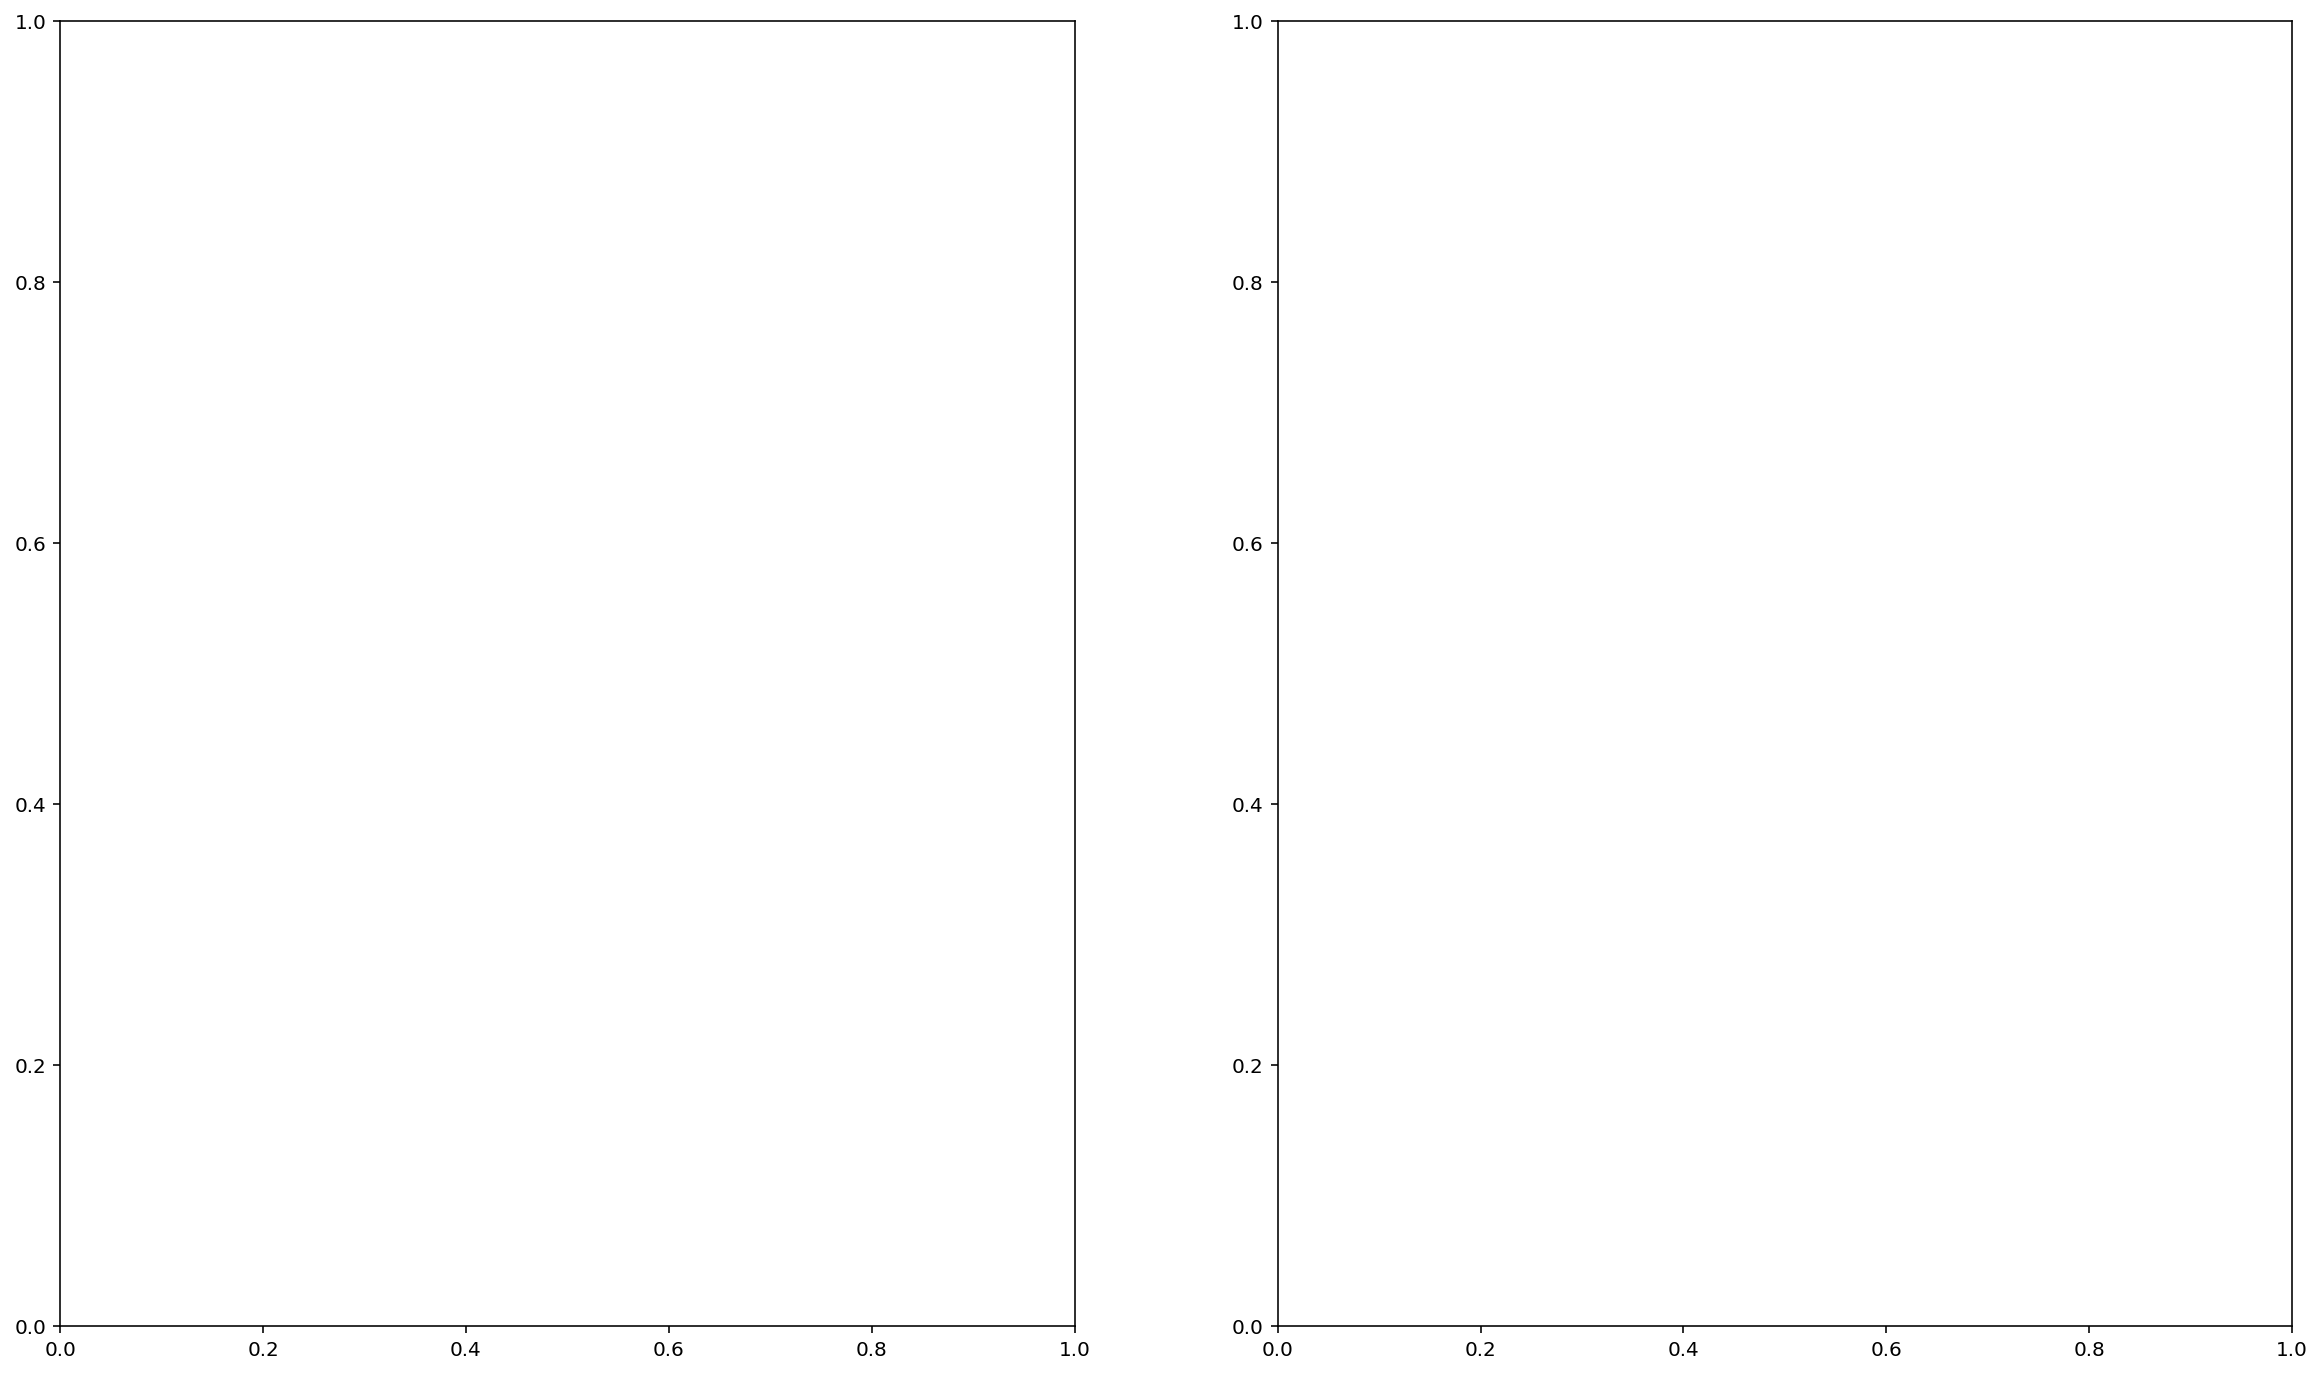

In [13]:
# Grid and plot overall chi^2 for each polarization
ee_chisq = np.vstack(np.array(list(chisq_ee_dict.values())))
nn_chisq = np.vstack(np.array(list(chisq_nn_dict.values())))
fig, axes = plt.subplots(1, 2, figsize=(20,12))

for ax, cs, t in zip(axes, [ee_chisq, nn_chisq], ['ee-polarized', 'nn-polarized']):
    extent=[hd.freqs[0]/1e6, hd.freqs[-1]/1e6, times[-1], times[0]]
    im = ax.imshow(cs / ~flag_mask, aspect='auto', vmin=0, cmap='inferno', vmax=10, interpolation='nearest', extent=extent)
    ax.imshow(blacklist, aspect='auto', cmap=my_cmap, interpolation=None, clim=[0.9, 1], alpha=.25, extent=extent)
    ax.set_title('Overall Abscal $\chi^2$ / $N_{bls}$: ' + t)
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('LST (Hours)')
    ax.set_yticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) for t in ax.get_yticks()]], 2))              
    plt.colorbar(im, ax=ax, label='$\chi^2$ / $N_{bls}$ (unitless)')

### Figure 3 Overall Abscal $\chi^2 / N_{bls}$

This computes the difference between the calibrated data and the abscal model, normalized by the thermal noise. Grayed out regions are "blacklisted," meaning they are not flagged but they are given zero weight when performing calibration smoothing.

#### OBSERVER CHECKLIST:
* Look for regions of high $\chi^2$ that are not blacklisted.

In [14]:
# Pick vmax to not saturate 90% of the data
vmax = np.max([np.percentile(np.abs(gains[ants_to_save[pol][1]][~flag_mask]), 90) for pol in ['Jee', 'Jnn']])

# Plot abscal gain amplitude waterfalls for a single antenna
fig, axes = plt.subplots(3, 2, figsize=(16,16), gridspec_kw={'height_ratios': [1, .25, .25]})
for ax, pol in zip(axes[0], ['Jee', 'Jnn']):
    ant = ants_to_save[pol][1]
    gains_here = deepcopy(gains[ant])
    gains_here[flags[ant]] = np.nan
    extent=[hd.freqs[0]/1e6, hd.freqs[-1]/1e6, times[-1], times[0]]
    im = ax.imshow(np.abs(gains_here), aspect='auto', cmap='inferno', 
                   interpolation='nearest', vmin=0, vmax=vmax, extent=extent)
    ax.imshow(blacklist, aspect='auto', cmap=my_cmap, interpolation=None, clim=[0.9, 1], alpha=.25, extent=extent)
    ax.set_title(f'Abscal Gain Amplitude of Antenna {ant[0]}: {pol[1:]}-polarized' )
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('LST (Hours)')        
    ax.set_yticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) for t in ax.get_yticks()]], 2))                      
    plt.colorbar(im, ax=ax,  orientation='horizontal', pad=.07)

# Now plot median gain spectra and time series
for ax, pol in zip(axes[1], ['Jee', 'Jnn']):
    ant = ants_to_save[pol][1]
    gains_here = deepcopy(gains[ant])
    gains_here[flags[ant]] = np.nan    
    if not np.all(np.hstack(time_blacklisted)):
        ax.plot(hd.freqs / 1e6, np.nanmedian(np.abs(gains_here[~np.hstack(time_blacklisted), :]), axis=0))
    ax.set_ylim([0, vmax])
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('|g| (unitless)')
    ax.set_title(f'Median Non-Blacklisted Abscal Gain Amplitude Spectrum of Antenna {ant[0]}: {pol[1:]}-polarized')

# Now plot median gain time series
for ax, pol in zip(axes[2], ['Jee', 'Jnn']):
    ant = ants_to_save[pol][1]
    gains_here = deepcopy(gains[ant])
    gains_here[flags[ant]] = np.nan    
    if not np.all(np.hstack(time_blacklisted)):
        ax.plot(lsts[~np.hstack(time_blacklisted)], 
                np.nanmedian(np.abs(gains_here[~np.hstack(time_blacklisted), :]), axis=1), 
                'b.', label='Not Blacklisted LSTs')
    if np.any(np.hstack(time_blacklisted)):
        ax.plot(lsts[np.hstack(time_blacklisted)], 
                np.nanmedian(np.abs(gains_here[np.hstack(time_blacklisted), :]), axis=1), 
                'r.', label='Blacklisted LSTs')
    ax.set_ylim([0, vmax])
    ax.set_xlabel('LST (hours)')
    ax.set_ylabel('|g| (unitless)')
    ax.set_title(f'Median Abscal Gain Amplitude Time-Series of Antenna {ant[0]}: {pol[1:]}-polarized')
    ax.legend()

plt.tight_layout()

NameError: name 'flag_mask' is not defined

### Figure 4: Example Abscal Gain Amplitudes
Abscal gain amplitudes for an example antenna. In the waterfall, grayed out regions are "blacklisted," meaning they are not flagged but they are given zero weight when performing calibration smoothing. We also plot median non-blacklisted amplitude as a function of frequency (middle row) and the median amplitude as a function of time (bottom row)

#### OBSERVER CHECKLIST:
* Look to see that non-blacklisted times are relatively stable in amplitude
* Check to see if the bandpass looks reasonable

NameError: name 'hd' is not defined

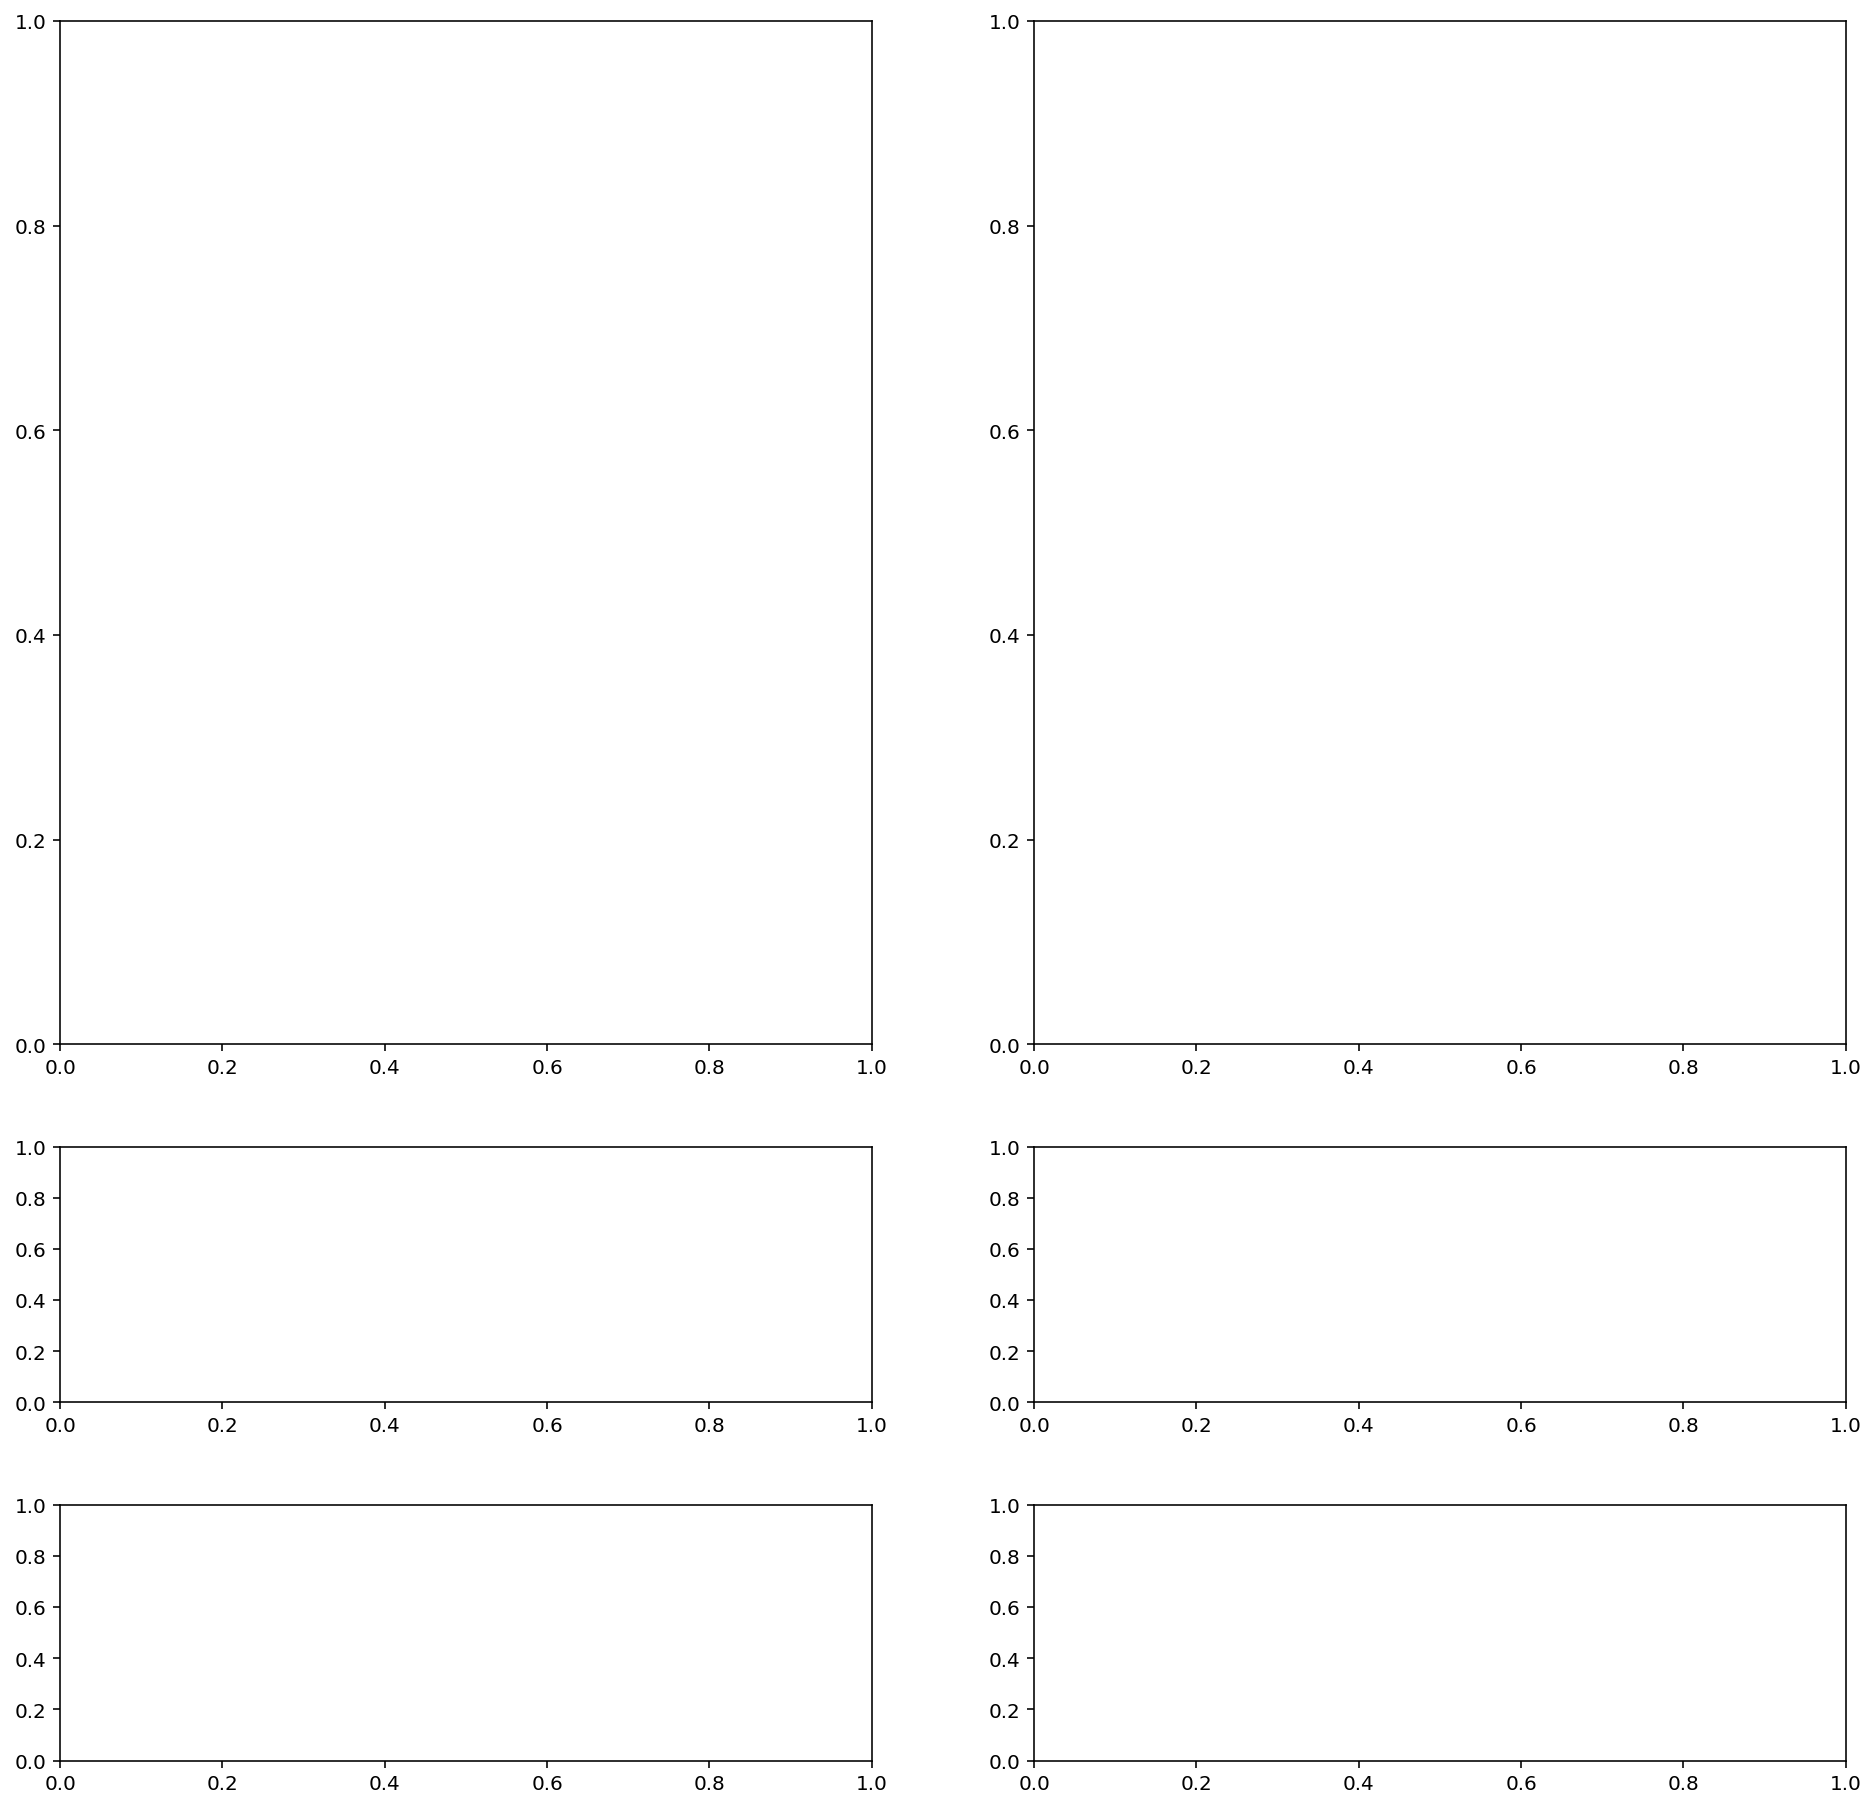

In [15]:
# Plot abscal gain phase waterfalls for a single antenna/refant
fig, axes = plt.subplots(3, 2, figsize=(16,16), gridspec_kw={'height_ratios': [1, .25, .25]})
for ax, pol in zip(axes[0], ['Jee', 'Jnn']):
    ant0, ant1 = ants_to_save[pol]
    gains_ratio_here = gains[ant0] / gains[ant1]
    gains_ratio_here[flags[ant0] | flags[ant1]] = np.nan
    extent=[hd.freqs[0]/1e6, hd.freqs[-1]/1e6, times[-1], times[0]]
    im = ax.imshow(np.angle(gains_ratio_here), aspect='auto', cmap='inferno', 
                   interpolation='nearest', vmin=-np.pi, vmax=np.pi, extent=extent)
    ax.imshow(blacklist, aspect='auto', cmap=my_cmap, interpolation=None, clim=[0.9, 1], alpha=.25, extent=extent)
    ax.set_title(f'Abscal Gain Phase of Ant {ant0[0]} / Ant {ant1[0]}: {pol[1:]}-polarized' )
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('LST (Hours)')
    ax.set_yticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) for t in ax.get_yticks()]], 2))                          
    plt.colorbar(im, ax=ax,  orientation='horizontal', pad=.07)

# Now plot median gain spectra and time series
for ax, pol in zip(axes[1], ['Jee', 'Jnn']):
    ant0, ant1 = ants_to_save[pol]
    gains_ratio_here = gains[ant0] / gains[ant1]
    gains_ratio_here[flags[ant0] | flags[ant1]] = np.nan    
    if not np.all(np.hstack(time_blacklisted)):
        re_med = np.nanmedian(gains_ratio_here[~np.hstack(time_blacklisted), :].real, axis=0)
        im_med = np.nanmedian(gains_ratio_here[~np.hstack(time_blacklisted), :].imag, axis=0)
        ax.plot(hd.freqs / 1e6, np.angle(re_med + 1.0j * im_med))
    ax.set_ylim([-np.pi, np.pi])
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel(f'Phase of g$_{{ant0[0]}}$ / g$_{{ant1[0]}}$')
    ax.set_title(f'Median Non-Blacklisted Abscal Gain Phase Spectrum of Ant {ant0[0]} / Ant {ant1[0]}: {pol[1:]}-polarized')

# Now plot a single gain angle time series 
for ax, pol in zip(axes[2], ['Jee', 'Jnn']):
    ant0, ant1 = ants_to_save[pol]
    gains_ratio_here = gains[ant0] / gains[ant1]
    gains_ratio_here[flags[ant0] | flags[ant1]] = np.nan        
    # pick channel with minimum phase variance in the middle 100 channels 
    possible_chans = np.arange(len(hd.freqs))[len(hd.freqs)//2 - 50:len(hd.freqs)//2 + 50]
    best_chan = np.argmin(np.var(np.angle(gains_ratio_here), axis=0)[len(hd.freqs)//2 - 50:len(hd.freqs)//2 + 50])
    chan = possible_chans[best_chan]
    
    if not np.all(np.hstack(time_blacklisted)):
        ax.plot(lsts[~np.hstack(time_blacklisted)], 
                np.angle(gains_ratio_here[~np.hstack(time_blacklisted), chan]),
                'b.', label='Not Blacklisted LSTs')
    if np.any(np.hstack(time_blacklisted)):
        ax.plot(lsts[np.hstack(time_blacklisted)], 
                np.angle(gains_ratio_here[np.hstack(time_blacklisted), chan]),
                'r.', label='Blacklisted LSTs')
    ax.set_ylim([-np.pi, np.pi])
    ax.set_xlabel('LST (hours)')
    ax.set_ylabel(f'Phase of g$_{ant0[0]}$ / g$_{ant1[0]}$')
    ax.set_title(f'Abscal Gain Phase of Ant {ant0[0]} / Ant {ant1[0]} at Channel {chan}: {pol[1:]}-polarized')
    ax.legend()

plt.tight_layout()

### Figure 5: Example Abscal Gain Phases
Relative gain phases of two example antennas. In the waterfall, grayed out regions are "blacklisted," meaning they are not flagged but they are given zero weight when performing calibration smoothing. We also plot median non-blacklisted phases as a function of frequency (middle row) and the phase of the specific channel within 50 channels of the middle with minimal phase variance (bottom row).

#### OBSERVER CHECKLIST:
* Look for regions of "hashy" phase structure that are not blacklisted or attributable to RFI.

# Metadata

In [16]:
print(redcal.version.history_string())


------------
This file was produced by the function <module>() in <ipython-input-16-c6de44361328> using: 
    git_branch: 
    git_description: 
    git_hash: 
    git_origin: 
    version: 3.0
------------

